In [1]:
import sys
sys.path.append("../")

import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import numpy as np

from models import DenseReparam, DenseWN
from utils import plot_loss
import matplotlib.pyplot as plt

GLOBAL_SEED = 0

os.environ['PYTHONHASHSEED']=str(GLOBAL_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
dtype = 'float64'
tf.keras.backend.set_floatx(dtype)

In [2]:
from sklearn.model_selection import train_test_split

banana_dataset = pd.read_csv("2d_banana.csv", sep=",")

x = banana_dataset[['At1','At2']].to_numpy()
y = banana_dataset.Class.to_numpy().reshape(-1, 1)
y[y==-1] = 0
num_data_points = 1000
random_idx = np.random.choice(x.shape[0], size=num_data_points, replace=False) 
x, y = x[random_idx, :], y[random_idx, :]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=GLOBAL_SEED)

# standardize features
train_mean = tf.reduce_mean(x_train, axis=0, keepdims=True)
train_std = tf.math.reduce_std(x_train, axis=0, keepdims=True)
x_train = (x_train - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

print("train set size:", x_train.shape, y_train.shape)
print("test set size:", x_test.shape, y_test.shape)

train set size: (800, 2) (800, 1)
test set size: (200, 2) (200, 1)


In [3]:
units = 10
n_epochs = 5000
batch_size = 128
early_stop_patience = 100

lr_gmp = 0.1
lr_others = 0.01

os.makedirs("./figs", exist_ok=True)

# Geometric Parameterization

In [4]:
def build_reparam_dnn_model(lr):
    model = tf.keras.Sequential([
        DenseReparam(units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [5]:
reparam_dnn_model = build_reparam_dnn_model(lr=lr_gmp)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=0, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=0, mode='max', restore_best_weights=True)

In [6]:
reparam_locs_x = [np.zeros(units)]
reparam_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = reparam_dnn_model.get_weights()[0]
    thetas = weights[0]
    lambdas = weights[1]

    reparam_locs_x.append(-1.0*lambdas*np.cos(thetas))
    reparam_locs_y.append(-1.0*lambdas*np.sin(thetas))

print_reparam_locs = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [7]:
history_reparam_dnn = reparam_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_reparam_locs, lr_decay, early_stop]
)

In [8]:
train_results_reparam_dnn = reparam_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_reparam_dnn[1])
test_results_reparam_dnn = reparam_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_reparam_dnn[1])

Train Accuracy: 0.905
Test Accuracy: 0.885


[4.98045337 1.63977601 2.61135458 2.10287739 3.73178016 3.53545166
 1.79213564 3.02490116 3.56197531 2.68167353]


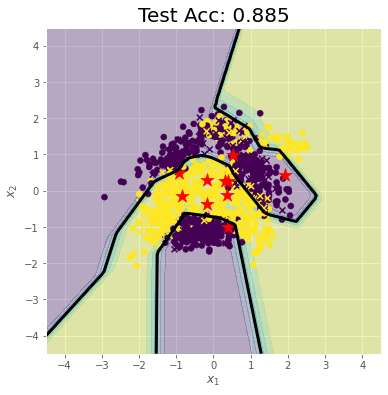

In [9]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = reparam_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = reparam_dnn_model.get_weights()[0]
thetas = weights[0]
lambdas = weights[1]
print(weights[2])

feature_locs_x = -1.0*lambdas*np.cos(thetas)
feature_locs_y = -1.0*lambdas*np.sin(thetas)
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_reparam_dnn[1]), fontsize=20)
plt.savefig("./figs/banana_gmp.pdf", format="pdf", bbox_inches="tight")

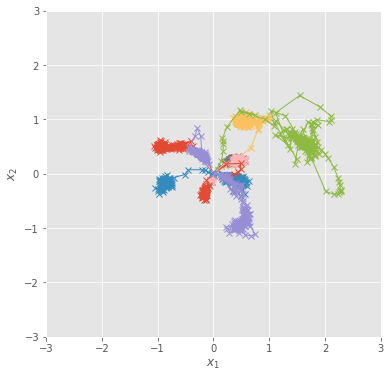

In [10]:
reparam_locs_x_np = np.vstack(reparam_locs_x).T
reparam_locs_y_np = np.vstack(reparam_locs_y).T

plt.figure(figsize=(6, 6))

for i in range(units):
    plt.plot(reparam_locs_x_np[i], reparam_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("./figs/banana_gmp_trajectory.pdf", format="pdf", bbox_inches="tight")

# Standard Parameterization

In [12]:
def build_dnn_model(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [13]:
dnn_model = build_dnn_model(lr_others)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=0, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=0, mode='max', restore_best_weights=True)

In [14]:
dnn_locs_x = [np.zeros(units)]
dnn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = dnn_model.get_weights()
    w = weights[0]
    b = weights[1]
    norm = np.linalg.norm(w, axis=0)

    dnn_locs_x.append(-1.0*b*w[0]/norm**2)
    dnn_locs_y.append(-1.0*b*w[1]/norm**2)

print_dnn_locs = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [15]:
history_dnn = dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_dnn_locs, lr_decay, early_stop]
)

In [16]:
train_results_dnn = dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_dnn[1])
test_results_dnn = dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_dnn[1])

Train Accuracy: 0.805
Test Accuracy: 0.8


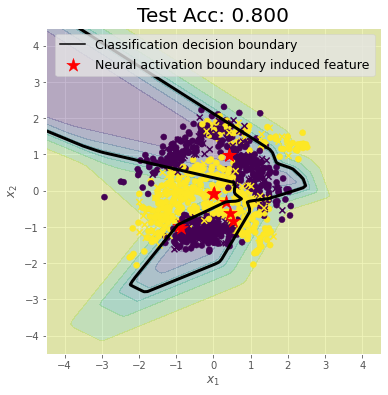

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = dnn_model.get_weights()
w = weights[0]
b = weights[1]
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Neural activation boundary induced feature", marker='*',s=200)

plt.title("Test Acc: {0:.3f}".format(test_results_dnn[1]), fontsize=20)
plt.legend(fontsize=12.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("./figs/banana_sp.pdf", format="pdf", bbox_inches="tight")

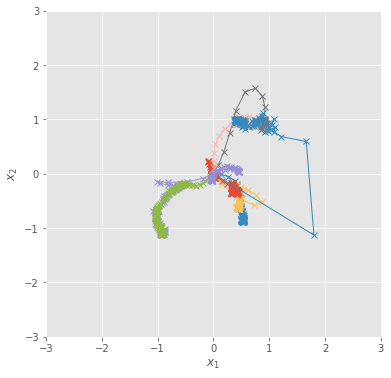

In [18]:
dnn_locs_x_np = np.vstack(dnn_locs_x).T
dnn_locs_y_np = np.vstack(dnn_locs_y).T

plt.figure(figsize=(6, 6))

for i in range(units):
    plt.plot(dnn_locs_x_np[i], dnn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("./figs/banana_sp_trajectory.pdf", format="pdf", bbox_inches="tight")

# Batch Normalization

In [20]:
def build_bn_dnn_model(lr):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [21]:
bn_dnn_model = build_bn_dnn_model(lr=lr_others)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=0, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=0, mode='max', restore_best_weights=True)

In [22]:
bn_locs_x = [np.zeros(units)]
bn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    bn_layer = bn_dnn_model.get_layer("batch_normalization")
    mu = bn_layer.moving_mean.numpy()
    sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
    gamma = bn_layer.gamma.numpy()
    beta = bn_layer.beta.numpy()

    weights = bn_dnn_model.get_weights()
    w = weights[0]
    b = weights[1] + sigma * beta / gamma - mu
    norm = np.linalg.norm(w, axis=0)

    bn_locs_x.append(-1.0*b*w[0]/norm**2)
    bn_locs_y.append(-1.0*b*w[1]/norm**2)

print_bn_locs = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [23]:
history_bn_dnn = bn_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_bn_locs, lr_decay, early_stop]
)

In [24]:
train_results_bn_dnn = bn_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_bn_dnn[1])
test_results_bn_dnn = bn_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_bn_dnn[1])

Train Accuracy: 0.88375
Test Accuracy: 0.875


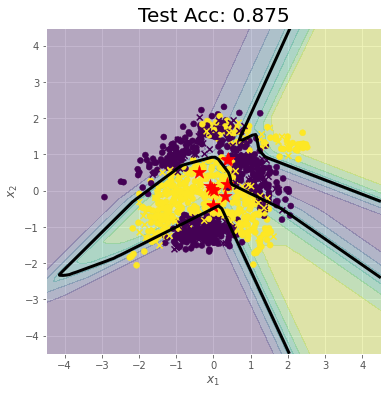

In [25]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = bn_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')

bn_layer = bn_dnn_model.get_layer("batch_normalization")
mu = bn_layer.moving_mean.numpy()
sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
gamma = bn_layer.gamma.numpy()
beta = bn_layer.beta.numpy()

weights = bn_dnn_model.get_weights()
w = weights[0]
b = weights[1] + sigma * beta / gamma - mu
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_bn_dnn[1]), fontsize=20)
plt.savefig("./figs/banana_batchnorm.pdf", format="pdf", bbox_inches="tight")

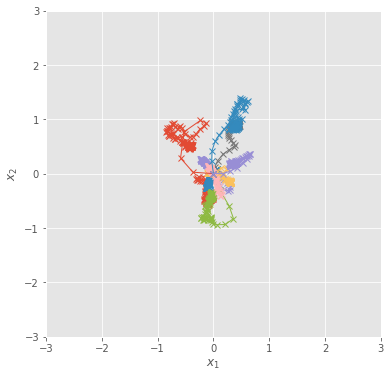

In [26]:
bn_locs_x_np = np.vstack(bn_locs_x).T
bn_locs_y_np = np.vstack(bn_locs_y).T

plt.figure(figsize=(6, 6))

for i in range(units):
    plt.plot(bn_locs_x_np[i], bn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("./figs/banana_batchnorm_trajectory.pdf", format="pdf", bbox_inches="tight")

# Weight Normalization

In [28]:
def build_wn_dnn_model(lr):
    model = tf.keras.Sequential([
        DenseWN(units, activation='relu'),
        DenseWN(1),
        tf.keras.layers.Activation('sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [29]:
wn_dnn_model = build_wn_dnn_model(lr=lr_others)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=0, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=0, mode='max', restore_best_weights=True)

In [30]:
wn_locs_x = [np.zeros(units)]
wn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = wn_dnn_model.get_weights()
    w = weights[0][:-2, :] / np.linalg.norm(weights[0][:-2, :], axis=0) * weights[0][-1:, :]
    b = weights[1][-2:-1, :]
    norm = np.linalg.norm(w, axis=0)

    wn_locs_x.append(-1.0*b*w[0]/norm**2)
    wn_locs_y.append(-1.0*b*w[1]/norm**2)

print_wn_locs = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [31]:
history_wn_dnn = wn_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_wn_locs, lr_decay, early_stop]
)

In [33]:
train_results_wn_dnn = wn_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_wn_dnn[1])
test_results_wn_dnn = wn_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_wn_dnn[1])

Train Accuracy: 0.81
Test Accuracy: 0.81


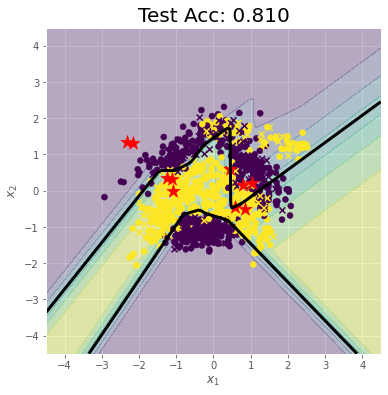

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = wn_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = wn_dnn_model.get_weights()
w = weights[0][:-2, :] / np.linalg.norm(weights[0][:-2, :], axis=0) * weights[0][-1:, :]
b = weights[1][-2:-1, :]
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_wn_dnn[1]), fontsize=20)
plt.savefig("./figs/banana_weightnorm.pdf", format="pdf", bbox_inches="tight")

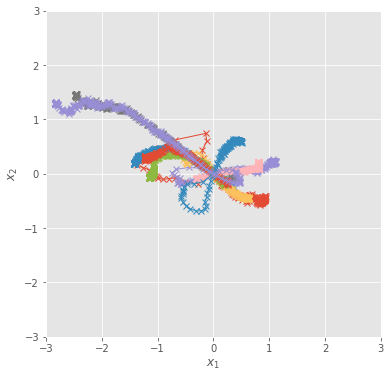

In [35]:
wn_locs_x_np = np.vstack(wn_locs_x).T
wn_locs_y_np = np.vstack(wn_locs_y).T

plt.figure(figsize=(6, 6))

for i in range(units):
    plt.plot(wn_locs_x_np[i], wn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("./figs/banana_weightnorm_trajectory.pdf", format="pdf", bbox_inches="tight")